In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from stabl.stabl import Stabl, plot_stabl_path, plot_fdr_graph, export_stabl_to_csv, save_stabl_results
from stabl.preprocessing import LowInfoFilter
from stabl.visualization import boxplot_features, scatterplot_features, plot_roc, boxplot_binary_predictions
from stabl.adaptive import ALasso, ALogitLasso
from stabl import data

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import clone
from sklearn.linear_model import Lasso, LogisticRegression, ElasticNet
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_formats=['retina']
random_state = 42

In [2]:
# Import data (Ages 8 to 40 with IIV vaccination, first visit only)
data_stabl = pd.read_csv("initial_dataset_20240715.csv")
data_stabl

,donor_id,outcome,age,bmi,gender,race,assay,data_name,subset,data
0,347,0,25.18,20.15,Female,Caucasian,7,IFNa_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,710.0
1,347,0,25.18,20.15,Female,Caucasian,7,IFNg_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,364.0
2,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_10_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,406.0
3,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_2_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,401.0
4,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_21_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,439.0
...,...,...,...,...,...,...,...,...,...,...
42554,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_2_Mono_pSTAT5,Mono: pSTAT5,554.0
42555,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_21_Mono_pSTAT5,Mono: pSTAT5,592.0
42556,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_6_Mono_pSTAT5,Mono: pSTAT5,556.0
42557,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_7_Mono_pSTAT5,Mono: pSTAT5,646.0


In [3]:
# Rename columns to fit in better terminology
data_stabl = data_stabl.rename(columns={"donor_id": "sample", 
                                 "data_name": "feature"})
data_stabl

,sample,outcome,age,bmi,gender,race,assay,feature,subset,data
0,347,0,25.18,20.15,Female,Caucasian,7,IFNa_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,710.0
1,347,0,25.18,20.15,Female,Caucasian,7,IFNg_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,364.0
2,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_10_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,406.0
3,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_2_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,401.0
4,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_21_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,439.0
...,...,...,...,...,...,...,...,...,...,...
42554,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_2_Mono_pSTAT5,Mono: pSTAT5,554.0
42555,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_21_Mono_pSTAT5,Mono: pSTAT5,592.0
42556,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_6_Mono_pSTAT5,Mono: pSTAT5,556.0
42557,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_7_Mono_pSTAT5,Mono: pSTAT5,646.0


## Data preprocessing

In [4]:
# Connect assay numbers to corresponding assay names
conditions = [
    (data_stabl['assay'] == 1),
    (data_stabl['assay'] == 2),
    (data_stabl['assay'] == 3),
    (data_stabl['assay'] == 4),
    (data_stabl['assay'] == 5),
    (data_stabl['assay'] == 6),
    (data_stabl['assay'] == 7),
    (data_stabl['assay'] == 9),
    (data_stabl['assay'] == 10),
    (data_stabl['assay'] == 11),
    (data_stabl['assay'] == 12),
    (data_stabl['assay'] == 13),
    (data_stabl['assay'] == 14),
    (data_stabl['assay'] == 15),
    (data_stabl['assay'] == 16)
]

values = ["CMV_EBV",
          "Other_immunoassay",
          "Human_Luminex 62_63 plex",
          "CyTOF_phenotyping",
          "HAI",
          "Human_Luminex_51_plex",
          "Phospho_flow_cytokine_stim_(PBMC)",
          "pCyTOF_(whole_blood)_pheno",
          "pCyTOF_(whole_blood)_phospho",
          "CBCD",
          "Human_MSD_4_plex",
          "Lyoplate_1",
          "Human_MSD_9_plex",
          "Human_Luminex_50_plex",
          "Other_Luminex"
         ]

data_stabl['assay_name'] = np.select(conditions, values, default = "Not Assigned")

data_stabl = data_stabl.rename(columns = {'assay':'assay_num', 'assay_name': 'assay'})

### Scaling & Removing Outliers

In [5]:
scaler = StandardScaler()

# Scale values by view
def scale_values(group):
    group['scaled_value'] = scaler.fit_transform(group[['data']])
    return group

data_stabl_scaled = data_stabl.groupby('assay').apply(scale_values)
data_stabl_scaled.reset_index(drop = True, inplace = True)

# Set scaled value as value for MoFA
data_stabl_scaled.rename(columns = {'data': 'nonscaled_value', 'scaled_value':'value'}, inplace = True)
data_stabl_scaled

,sample,outcome,age,bmi,gender,race,assay_num,feature,subset,nonscaled_value,assay,value
0,347,0,25.18,20.15,Female,Caucasian,11,BASO_,Basophil-%,0.40,CBCD,-0.511175
1,347,0,25.18,20.15,Female,Caucasian,11,BASO_CT,Basophil Absolute Count-K/uL,0.02,CBCD,-0.517414
2,347,0,25.18,20.15,Female,Caucasian,11,CELL_HEMOGL,Mean Cell Hemoglobin-pg/cell,29.50,CBCD,-0.033419
3,347,0,25.18,20.15,Female,Caucasian,11,CELL_HEMOGL_CONC,Mean Cell Hemoglobin Concentration-g/dL,33.80,CBCD,0.037177
4,347,0,25.18,20.15,Female,Caucasian,11,CELL_VOL,Mean Cell Volume-femtoliter,87.30,CBCD,0.915526
...,...,...,...,...,...,...,...,...,...,...,...,...
42554,190,0,10.36,NaN,Female,Other,10,IL_neg_7_transitional_B_cells_pSTAT1,CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.17,pCyTOF_(whole_blood)_phospho,-0.318097
42555,190,0,10.36,NaN,Female,Other,10,LPS_transitional_B_cells_pSTAT1,CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.16,pCyTOF_(whole_blood)_phospho,-0.336802
42556,190,0,10.36,NaN,Female,Other,10,PMA_Iono_transitional_B_cells_pSTAT1,CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.14,pCyTOF_(whole_blood)_phospho,-0.374214
42557,190,0,10.36,NaN,Female,Other,10,Unstim_transitional_B_cells_pSTAT1,CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.21,pCyTOF_(whole_blood)_phospho,-0.243273


In [6]:
# Remove outliers 1.5 IQR beyond Q1 and Q3
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR # Define bounds for outliers
    upper_bound = Q3 + 1.5*IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply outlier removing on each view
cleaned_data_stabl = data_stabl_scaled.groupby('assay').apply(remove_outliers, 'value').reset_index(drop=True)

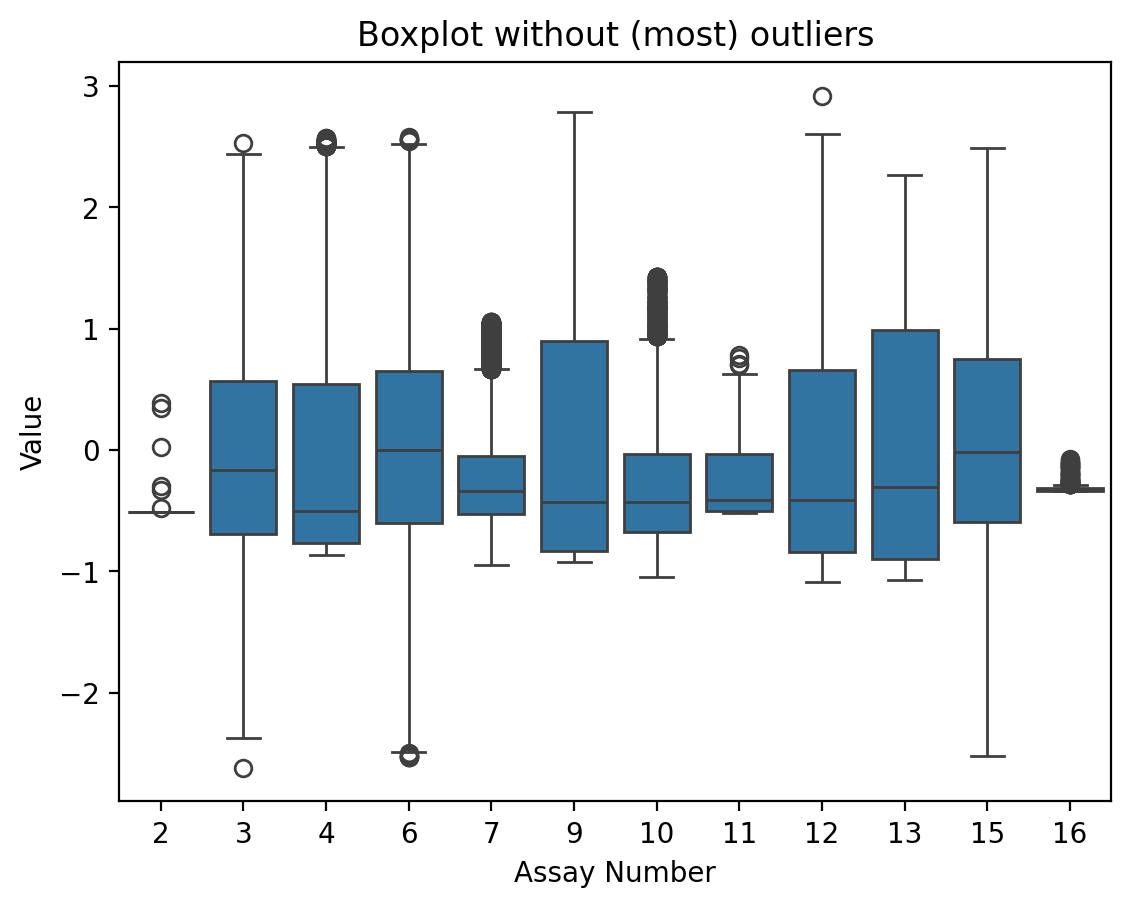

In [7]:
# Graph of data values after scaling and removing of (most) outliers
sns.boxplot(x='assay_num', y = 'value', data=cleaned_data_stabl)
plt.xlabel('Assay Number')
plt.ylabel('Value')
plt.title('Boxplot without (most) outliers')
plt.show()

### Combining Luminex Assays

In [8]:
# Specify the assays of interest
luminex_views = ["Human_Luminex 62_63 plex", "Human_Luminex_50_plex", "Human_Luminex_51_plex"]

# Group by 'assay' and aggregate 'feature' values into a set
grouped_features = cleaned_data_stabl[cleaned_data_stabl['assay'].isin(luminex_views)].groupby('assay')['feature'].apply(set)

# Find common features among the specified Luminex assays
common_features = set.intersection(*grouped_features)

# Remove rows with features that are not common among these 3 assays
filtered_data_stabl = cleaned_data_stabl[~(cleaned_data_stabl['assay'].isin(luminex_views) & ~(cleaned_data_stabl['feature'].isin(common_features)))]

# Change assay name to 'Luminex_combined' for these 3 assays
filtered_data_stabl.loc[filtered_data_stabl['assay'].isin(luminex_views), 'assay'] = 'Luminex_combined'

In [9]:
# Updated number of features per assay
feature_counts = filtered_data_stabl.groupby('assay')['feature'].nunique()
print(feature_counts)

assay
CBCD                                   18
CyTOF_phenotyping                      76
Human_MSD_4_plex                        4
Lyoplate_1                             65
Other_Luminex                          38
Other_immunoassay                       2
Phospho_flow_cytokine_stim_(PBMC)     274
pCyTOF_(whole_blood)_pheno            312
pCyTOF_(whole_blood)_phospho         2286
Name: feature, dtype: int64


### Dropping Low-Feature Assays

In [10]:
# Identify views with less than 15 features
views_to_remove = feature_counts[feature_counts < 15].index.tolist()
# Filter data_mofa_updated to only include rows where assay is not in views_to_remove
filtered_data_stabl = filtered_data_stabl[~filtered_data_stabl['assay'].isin(views_to_remove)]

# Count unique features for each assay
feature_counts_updated = filtered_data_stabl.groupby('assay')['feature'].nunique()
print(feature_counts_updated)

assay
CBCD                                   18
CyTOF_phenotyping                      76
Lyoplate_1                             65
Other_Luminex                          38
Phospho_flow_cytokine_stim_(PBMC)     274
pCyTOF_(whole_blood)_pheno            312
pCyTOF_(whole_blood)_phospho         2286
Name: feature, dtype: int64


### Addressing samples where there is a repeated combination of feature and view with different subsets (and values)

In [11]:
# Displaying instances of duplicate combinations of feature and assay 
duplicated_rows = filtered_data_stabl[filtered_data_stabl.duplicated(subset=['sample', 'outcome', 'age', 'assay', 'feature', 'bmi', 'gender', 'race'], keep=False)]
duplicated_rows

,sample,outcome,age,bmi,gender,race,assay_num,feature,subset,nonscaled_value,assay,value
18262,445,0,9.82,14.52,Female,Caucasian,13,monocytes,CXCR3 FMO: Mono,6.88,Lyoplate_1,-0.844012
18263,445,0,9.82,14.52,Female,Caucasian,13,monocytes,CXCR3: Mono,7.29,Lyoplate_1,-0.830335
18267,445,0,9.82,14.52,Female,Caucasian,13,NK_cells,CXCR3 FMO: Lymph/CD16+/CD56+,8.89,Lyoplate_1,-0.776961
18268,445,0,9.82,14.52,Female,Caucasian,13,NK_cells,CXCR3: Lymph/CD16+/CD56+,9.43,Lyoplate_1,-0.758947
18269,445,0,9.82,14.52,Female,Caucasian,13,NK_cells,NK-NKT: Lymph/CD3-/CD16+/CD56+,14.40,Lyoplate_1,-0.593154
...,...,...,...,...,...,...,...,...,...,...,...,...
18760,438,0,9.47,NaN,Male,Caucasian,13,T_cells,T cell: Lymph/CD3+,82.50,Lyoplate_1,1.678576
18761,438,0,9.47,NaN,Male,Caucasian,13,T_cells,Treg: Lymph/CD3+,82.10,Lyoplate_1,1.665233
18766,438,0,9.47,NaN,Male,Caucasian,13,B_cells,B cell: Lymph/CD3-/CD19+CD20+,8.83,Lyoplate_1,-0.778962
18767,438,0,9.47,NaN,Male,Caucasian,13,B_cells,CXCR3 FMO: Lymph/CD3-/CD19+CD20+,10.30,Lyoplate_1,-0.729925


In [12]:
# Removing duplicate instances by creating completely unique features by adding subset to feature column
filtered_data_stabl['feature'] = filtered_data_stabl['feature'] + ', subset: ' + filtered_data_stabl['subset']

In [13]:
# All instances of duplicate combinations of feature and assay are gone
duplicated_rows = filtered_data_stabl[filtered_data_stabl.duplicated(subset=['sample', 'outcome', 'age', 'assay', 'feature', 'bmi', 'gender', 'race'], keep=False)]
duplicated_rows

,sample,outcome,age,bmi,gender,race,assay_num,feature,subset,nonscaled_value,assay,value


### Preparation of data to input into Stabl

In [14]:
# Transformation of data format to have sample as index and each feature as a column
final_stabl_data = filtered_data_stabl.pivot_table(index=['sample', 'outcome'],
                                           columns='feature',
                                           values='value').reset_index()
final_stabl_data.columns.name = None
final_stabl_data = final_stabl_data.set_index('sample')

final_stabl_data

,outcome,"BASO_, subset: Basophil-%","BASO_CT, subset: Basophil Absolute Count-K/uL","B_cells, subset: B cell: Lymph/CD3-/CD19+CD20+","B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+","B_cells, subset: CXCR3 FMO: Lymph/CD3-/CD19+CD20+","B_cells, subset: CXCR3: Lymph/CD3-/CD19+CD20+","CD161_neg_CD45RA_pos_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161-CD45RA+","CD161_neg_CD45RA_pos_Tregs, subset: Treg: Lymph/CD3+/CD4+/CD25hiCD127low/Q1: CD161-CD45RA+","CD161_pos_CD45RA_neg_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161+CD45RA-",...,"naive_B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+/CD24-CD38+","naive_CD4_pos_T_cells, subset: CD14-CD33-/CD3+/CD4+/CCR7+CD45RA+","naive_CD4_pos_T_cells, subset: T cell: Lymph/CD3+/CD4+/Q2: CD45RA+CD27+","naive_CD8_pos_T_cells, subset: CD14-CD33-/CD3+/CD8+/CCR7+CD45RA+","naive_CD8_pos_T_cells, subset: T cell: Lymph/CD3+/CD8+/Q2: CD45RA+CD27+","pDCs, subset: Nonbasophils/Nonbasophil CD14-CD33-/Nonbasophil CD3-CD20-/Nonbasophil CD56-CD16-/pDCs","plasmablasts, subset: B cell: Lymph/CD3-/CD20-/CD27+/CD38+","plasmablasts, subset: CD14-CD33-/CD3-/CD20-/CD27+CD38+","transitional_B_cells, subset: B cell: Lymph/CD3-/CD19+CD20+/CD24+/CD38+","transitional_B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+/CD24+CD38+"
sample,,,,,,,,,,,,,,,,,,,,,
53,0,NaN,NaN,NaN,1.464929,NaN,NaN,0.127280,NaN,-0.674959,...,1.605365,1.686115,NaN,0.724131,NaN,-0.146570,NaN,-0.782392,NaN,-0.635286
54,0,NaN,NaN,NaN,1.401733,NaN,NaN,0.344955,NaN,-0.579112,...,1.924856,1.615897,NaN,1.559723,NaN,0.239628,NaN,-0.801702,NaN,-0.667235
56,0,NaN,NaN,NaN,1.475462,NaN,NaN,-0.490637,NaN,-0.548216,...,2.174129,0.987448,NaN,2.142531,NaN,0.229095,NaN,-0.829789,NaN,-0.814693
57,0,NaN,NaN,NaN,1.096286,NaN,NaN,-0.541896,NaN,-0.567175,...,2.110933,1.019046,NaN,1.170014,NaN,-0.311582,NaN,-0.838918,NaN,-0.810831
64,0,NaN,NaN,NaN,2.065292,NaN,NaN,0.408151,NaN,-0.709717,...,2.282967,1.243743,NaN,0.446771,NaN,0.134301,NaN,-0.783797,NaN,-0.673555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
730,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
731,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Split the data including 'sample'
train_df, test_df = train_test_split(
    final_stabl_data, test_size=0.2, random_state=42, stratify=final_stabl_data['outcome']
)

# Extract X and y from the training data
train_x, train_y = train_df.drop(columns=['outcome']), train_df['outcome']

# Extract X and y from the test data
test_x, test_y = test_df.drop(columns=['outcome']), test_df['outcome']

In [16]:
train_x

,"BASO_, subset: Basophil-%","BASO_CT, subset: Basophil Absolute Count-K/uL","B_cells, subset: B cell: Lymph/CD3-/CD19+CD20+","B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+","B_cells, subset: CXCR3 FMO: Lymph/CD3-/CD19+CD20+","B_cells, subset: CXCR3: Lymph/CD3-/CD19+CD20+","CD161_neg_CD45RA_pos_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161-CD45RA+","CD161_neg_CD45RA_pos_Tregs, subset: Treg: Lymph/CD3+/CD4+/CD25hiCD127low/Q1: CD161-CD45RA+","CD161_pos_CD45RA_neg_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161+CD45RA-","CD161_pos_CD45RA_neg_Tregs, subset: Treg: Lymph/CD3+/CD4+/CD25hiCD127low/Q3: CD161+CD45RA-",...,"naive_B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+/CD24-CD38+","naive_CD4_pos_T_cells, subset: CD14-CD33-/CD3+/CD4+/CCR7+CD45RA+","naive_CD4_pos_T_cells, subset: T cell: Lymph/CD3+/CD4+/Q2: CD45RA+CD27+","naive_CD8_pos_T_cells, subset: CD14-CD33-/CD3+/CD8+/CCR7+CD45RA+","naive_CD8_pos_T_cells, subset: T cell: Lymph/CD3+/CD8+/Q2: CD45RA+CD27+","pDCs, subset: Nonbasophils/Nonbasophil CD14-CD33-/Nonbasophil CD3-CD20-/Nonbasophil CD56-CD16-/pDCs","plasmablasts, subset: B cell: Lymph/CD3-/CD20-/CD27+/CD38+","plasmablasts, subset: CD14-CD33-/CD3-/CD20-/CD27+CD38+","transitional_B_cells, subset: B cell: Lymph/CD3-/CD19+CD20+/CD24+/CD38+","transitional_B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+/CD24+CD38+"
sample,,,,,,,,,,,,,,,,,,,,,
283,NaN,NaN,NaN,0.464325,NaN,NaN,-0.216788,NaN,-0.862792,NaN,...,2.153064,0.748707,NaN,1.854638,NaN,NaN,NaN,-0.816799,NaN,-0.847344
211,NaN,NaN,NaN,0.573163,NaN,NaN,-0.178168,NaN,-0.712526,NaN,...,1.538658,1.124373,NaN,1.205123,NaN,-0.672853,NaN,-0.843131,NaN,-0.822416
178,NaN,NaN,NaN,1.054155,NaN,NaN,0.257183,NaN,-0.710419,NaN,...,1.703670,1.658028,NaN,1.924856,NaN,-0.841375,NaN,-0.827332,NaN,-0.791521
328,NaN,NaN,NaN,0.576674,NaN,NaN,0.285270,NaN,-0.856472,NaN,...,2.440957,0.292291,NaN,0.674979,NaN,NaN,NaN,-0.850855,NaN,-0.848046
284,NaN,NaN,NaN,0.327400,NaN,NaN,-0.476594,NaN,-0.847695,NaN,...,2.012628,0.411662,NaN,-0.083374,NaN,NaN,NaN,-0.775371,NaN,-0.810128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,NaN,NaN,NaN,0.650402,NaN,NaN,0.257183,NaN,-0.848046,NaN,...,2.188173,0.889143,NaN,1.988052,NaN,NaN,NaN,-0.835758,NaN,-0.828034
198,NaN,NaN,NaN,0.741686,NaN,NaN,-0.037732,NaN,-0.651436,NaN,...,2.002096,0.271226,NaN,0.137812,NaN,-0.711472,NaN,-0.767998,NaN,-0.734644
218,NaN,NaN,NaN,1.124373,NaN,NaN,0.186965,NaN,-0.596315,NaN,...,2.163597,0.878610,NaN,0.878610,NaN,-0.825225,NaN,-0.838918,NaN,-0.810128


## Running Stabl

### Final Preprocessing

In [17]:
# Preprocessing pipeline
preprocessing = Pipeline(
    steps=[
        ("variance_threshold", VarianceThreshold(threshold=0)),  # Removing 0 variance features
        ("low_info_filter", LowInfoFilter(max_nan_fraction=0.4)), # Removing features with high percentages of missing values
        ("imputer", KNNImputer(n_neighbors=3)),  # Imputing missing values with KNN
        ("std", StandardScaler())  # Z-scoring features
    ]
)

In [18]:
# Create new dataframe for input data
x_train_final = pd.DataFrame(
    data=preprocessing.fit_transform(train_x),
    index=train_x.index,
    columns=preprocessing.get_feature_names_out()
)

In [19]:
x_train_final

,"B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+","CD161_neg_CD45RA_pos_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161-CD45RA+","CD161_pos_CD45RA_neg_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161+CD45RA-","CD161_pos_CD45RA_pos_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161+CD45RA+","CD161_pos_CD4_pos_T_cells, subset: CD14-CD33-/CD3+/CD4+/CD161+","CD161_pos_CD8_pos_T_cells, subset: CD14-CD33-/CD3+/CD8+/CD161+","CD161_pos_NK_cells, subset: CD14-CD33-/CD3-/CD16+CD56+/CD161+","CD16_pos_monocytes, subset: CD14+CD33+/CD16+","CD27_pos_CD8_pos_T_cells, subset: CD14-CD33-/CD3+/CD8+/CD27+","CD28_pos_CD8_pos_T_cells, subset: CD14-CD33-/CD3+/CD8+/CD28+",...,"effector_memory_CD4_pos_T_cells, subset: CD14-CD33-/CD3+/CD4+/CCR7-CD45RA-","effector_memory_CD8_pos_T_cells, subset: CD14-CD33-/CD3+/CD8+/CCR7-CD45RA-","gamma_neg_delta_T_cells, subset: CD14-CD33-/TCRgd+","memory_B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+/CD24+CD38-","monocytes, subset: CD14+CD33+","naive_B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+/CD24-CD38+","naive_CD4_pos_T_cells, subset: CD14-CD33-/CD3+/CD4+/CCR7+CD45RA+","naive_CD8_pos_T_cells, subset: CD14-CD33-/CD3+/CD8+/CCR7+CD45RA+","plasmablasts, subset: CD14-CD33-/CD3-/CD20-/CD27+CD38+","transitional_B_cells, subset: CD14-CD33-/CD3-/CD19+CD20+/CD24+CD38+"
sample,,,,,,,,,,,,,,,,,,,,,
283,-0.670763,-6.769017e-01,-1.096645,-8.181100e-01,-0.554060,-1.434086,0.287818,-1.091139e+00,0.457280,0.440050,...,0.326039,-1.377381,-7.413276e-01,-4.243761e-01,-8.988071e-01,4.655486e-01,-0.224757,1.632330,0.140567,-1.312934
211,-0.410549,-6.049229e-01,0.695560,4.972992e-01,-0.272359,-0.848319,1.413671,9.832557e-02,0.209390,0.645042,...,-0.885556,-0.097581,-9.010985e-01,2.675982e+00,8.721406e-01,-2.372005e+00,0.613373,0.509874,-0.706190,-0.834206
178,0.739427,2.064749e-01,0.720685,6.617253e-01,-0.932899,-1.092526,1.180953,-4.481850e-01,1.176961,1.563408,...,-1.355049,-1.360880,-9.916354e-01,1.790165e+00,-8.972302e-01,-1.609919e+00,1.803988,1.753677,-0.198136,-0.240852
328,-0.402155,2.588232e-01,-1.021272,-8.181100e-01,-1.238884,-1.242680,-2.127420,-1.055776e+00,-1.046053,-0.666908,...,1.325605,-0.390945,-6.720935e-01,-1.441425e+00,2.571187e-01,1.795145e+00,-1.243047,-0.406292,-0.954572,-1.326419
284,-0.998128,-1.161123e+00,-0.916587,-3.013421e-01,1.553839,1.253844,0.577144,9.791720e-01,-0.830149,-0.461916,...,0.946982,2.065977,4.303260e-01,2.645922e-01,-9.981568e-01,-1.830350e-01,-0.976725,-1.716836,1.472797,-0.598213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,-0.225881,2.064749e-01,-0.920774,-8.181100e-01,-0.850331,-1.363134,-0.599027,-1.184367e+00,0.865099,0.349854,...,0.416909,-1.643242,-1.114126e+00,-5.884162e-01,-9.508474e-01,6.276945e-01,0.088562,1.862889,-0.469098,-0.942088
198,-0.007638,-3.431817e-01,1.424167,3.316033e+00,-0.221361,1.550853,0.162024,-7.375141e-01,0.582558,1.071427,...,1.567924,2.524358,1.607305e+00,1.661682e-01,-6.259897e-01,-2.316787e-01,-1.290045,-1.334594,1.709889,0.851457
218,0.907307,7.560431e-02,2.081588,1.883177e+00,1.505270,-0.858219,-0.429206,-1.242233e+00,-1.301939,-0.183126,...,-0.416063,0.562487,-8.212130e-01,-2.275280e-01,-4.682918e-01,5.141924e-01,0.065063,-0.054387,-0.570709,-0.598213


In [20]:
# Linear regression model for Stabl
logit_lasso = LogisticRegression(penalty="l1", max_iter=int(1e7), solver="liblinear", class_weight="balanced", random_state=random_state)
logit_en = LogisticRegression(penalty="elasticnet", max_iter=int(1e7), solver="saga", class_weight="balanced", random_state=random_state)

### Stabl feature selection

Stabl progress: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]
['Assay of CD161_pos_CD45RA_pos_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161+CD45RA+ is: CyTOF_phenotyping']
['Assay of NKT_cells, subset: CD14-CD33-/CD3+/CD56+ is: CyTOF_phenotyping']
['Assay of monocytes, subset: CD14+CD33+ is: CyTOF_phenotyping']


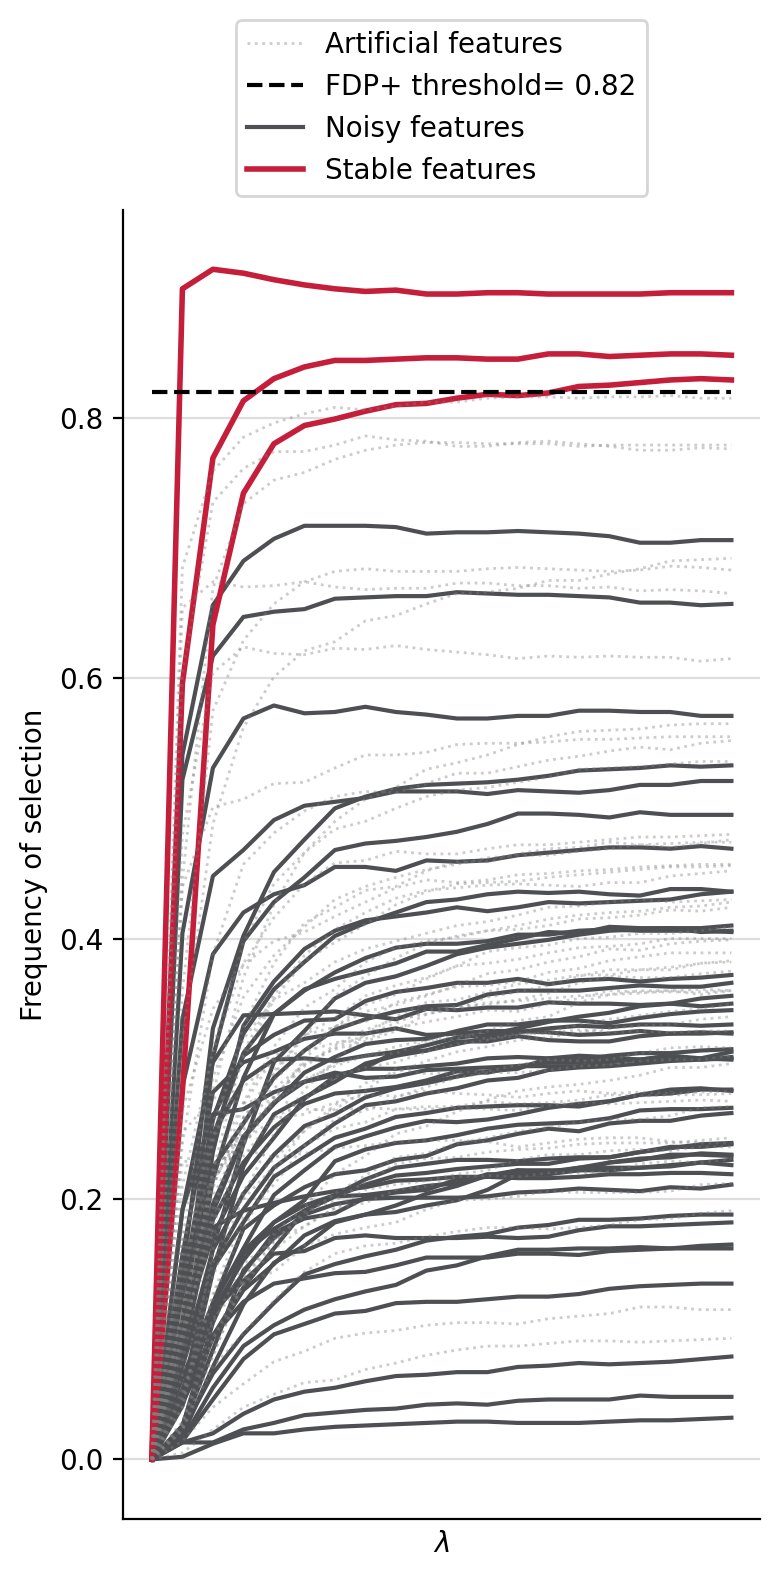

In [21]:
stabl_class = Stabl(
    base_estimator=clone(logit_lasso),
    lambda_grid="auto",
    n_lambda=20,
    artificial_type = 'knockoff',
    n_bootstraps=1000,
    random_state=4998, # Changed random state
    verbose=1
)
            
stabl_class.fit(x_train_final, train_y)
plot_stabl_path(stabl_class)
stable_features = stabl_class.get_feature_names_out()
for feature in stable_features:
    print("Assay of " + feature + " is: " + filtered_data_stabl[filtered_data_stabl['feature'] == feature]['assay'].unique())

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Threshold'>)

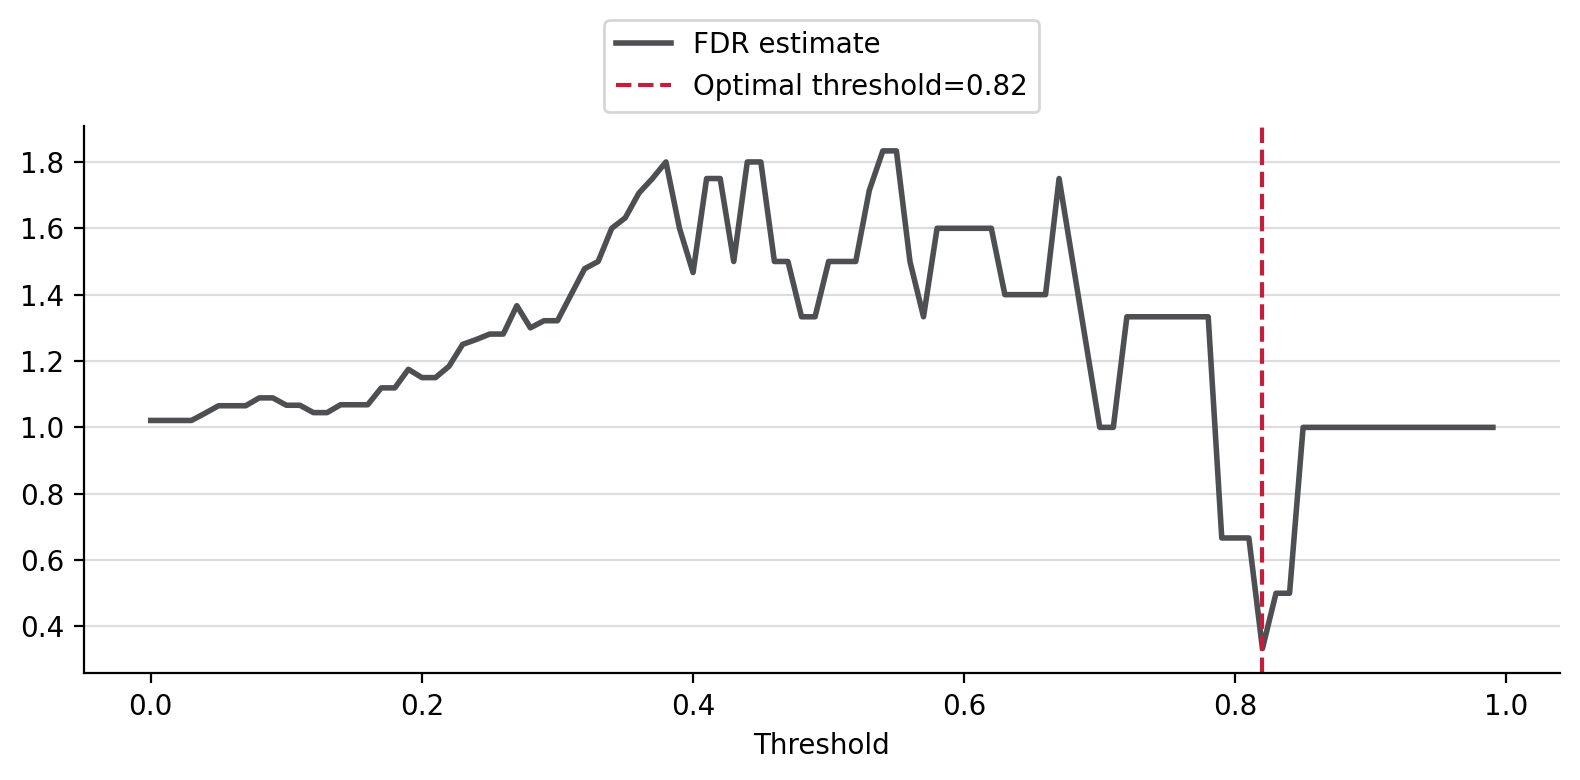

In [22]:
plot_fdr_graph(stabl_class)

Stabl progress: 100%|██████████| 60/60 [1:21:41<00:00, 81.69s/it]     
['Assay of CD161_pos_CD45RA_pos_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161+CD45RA+ is: CyTOF_phenotyping']
['Assay of NKT_cells, subset: CD14-CD33-/CD3+/CD56+ is: CyTOF_phenotyping']
['Assay of monocytes, subset: CD14+CD33+ is: CyTOF_phenotyping']


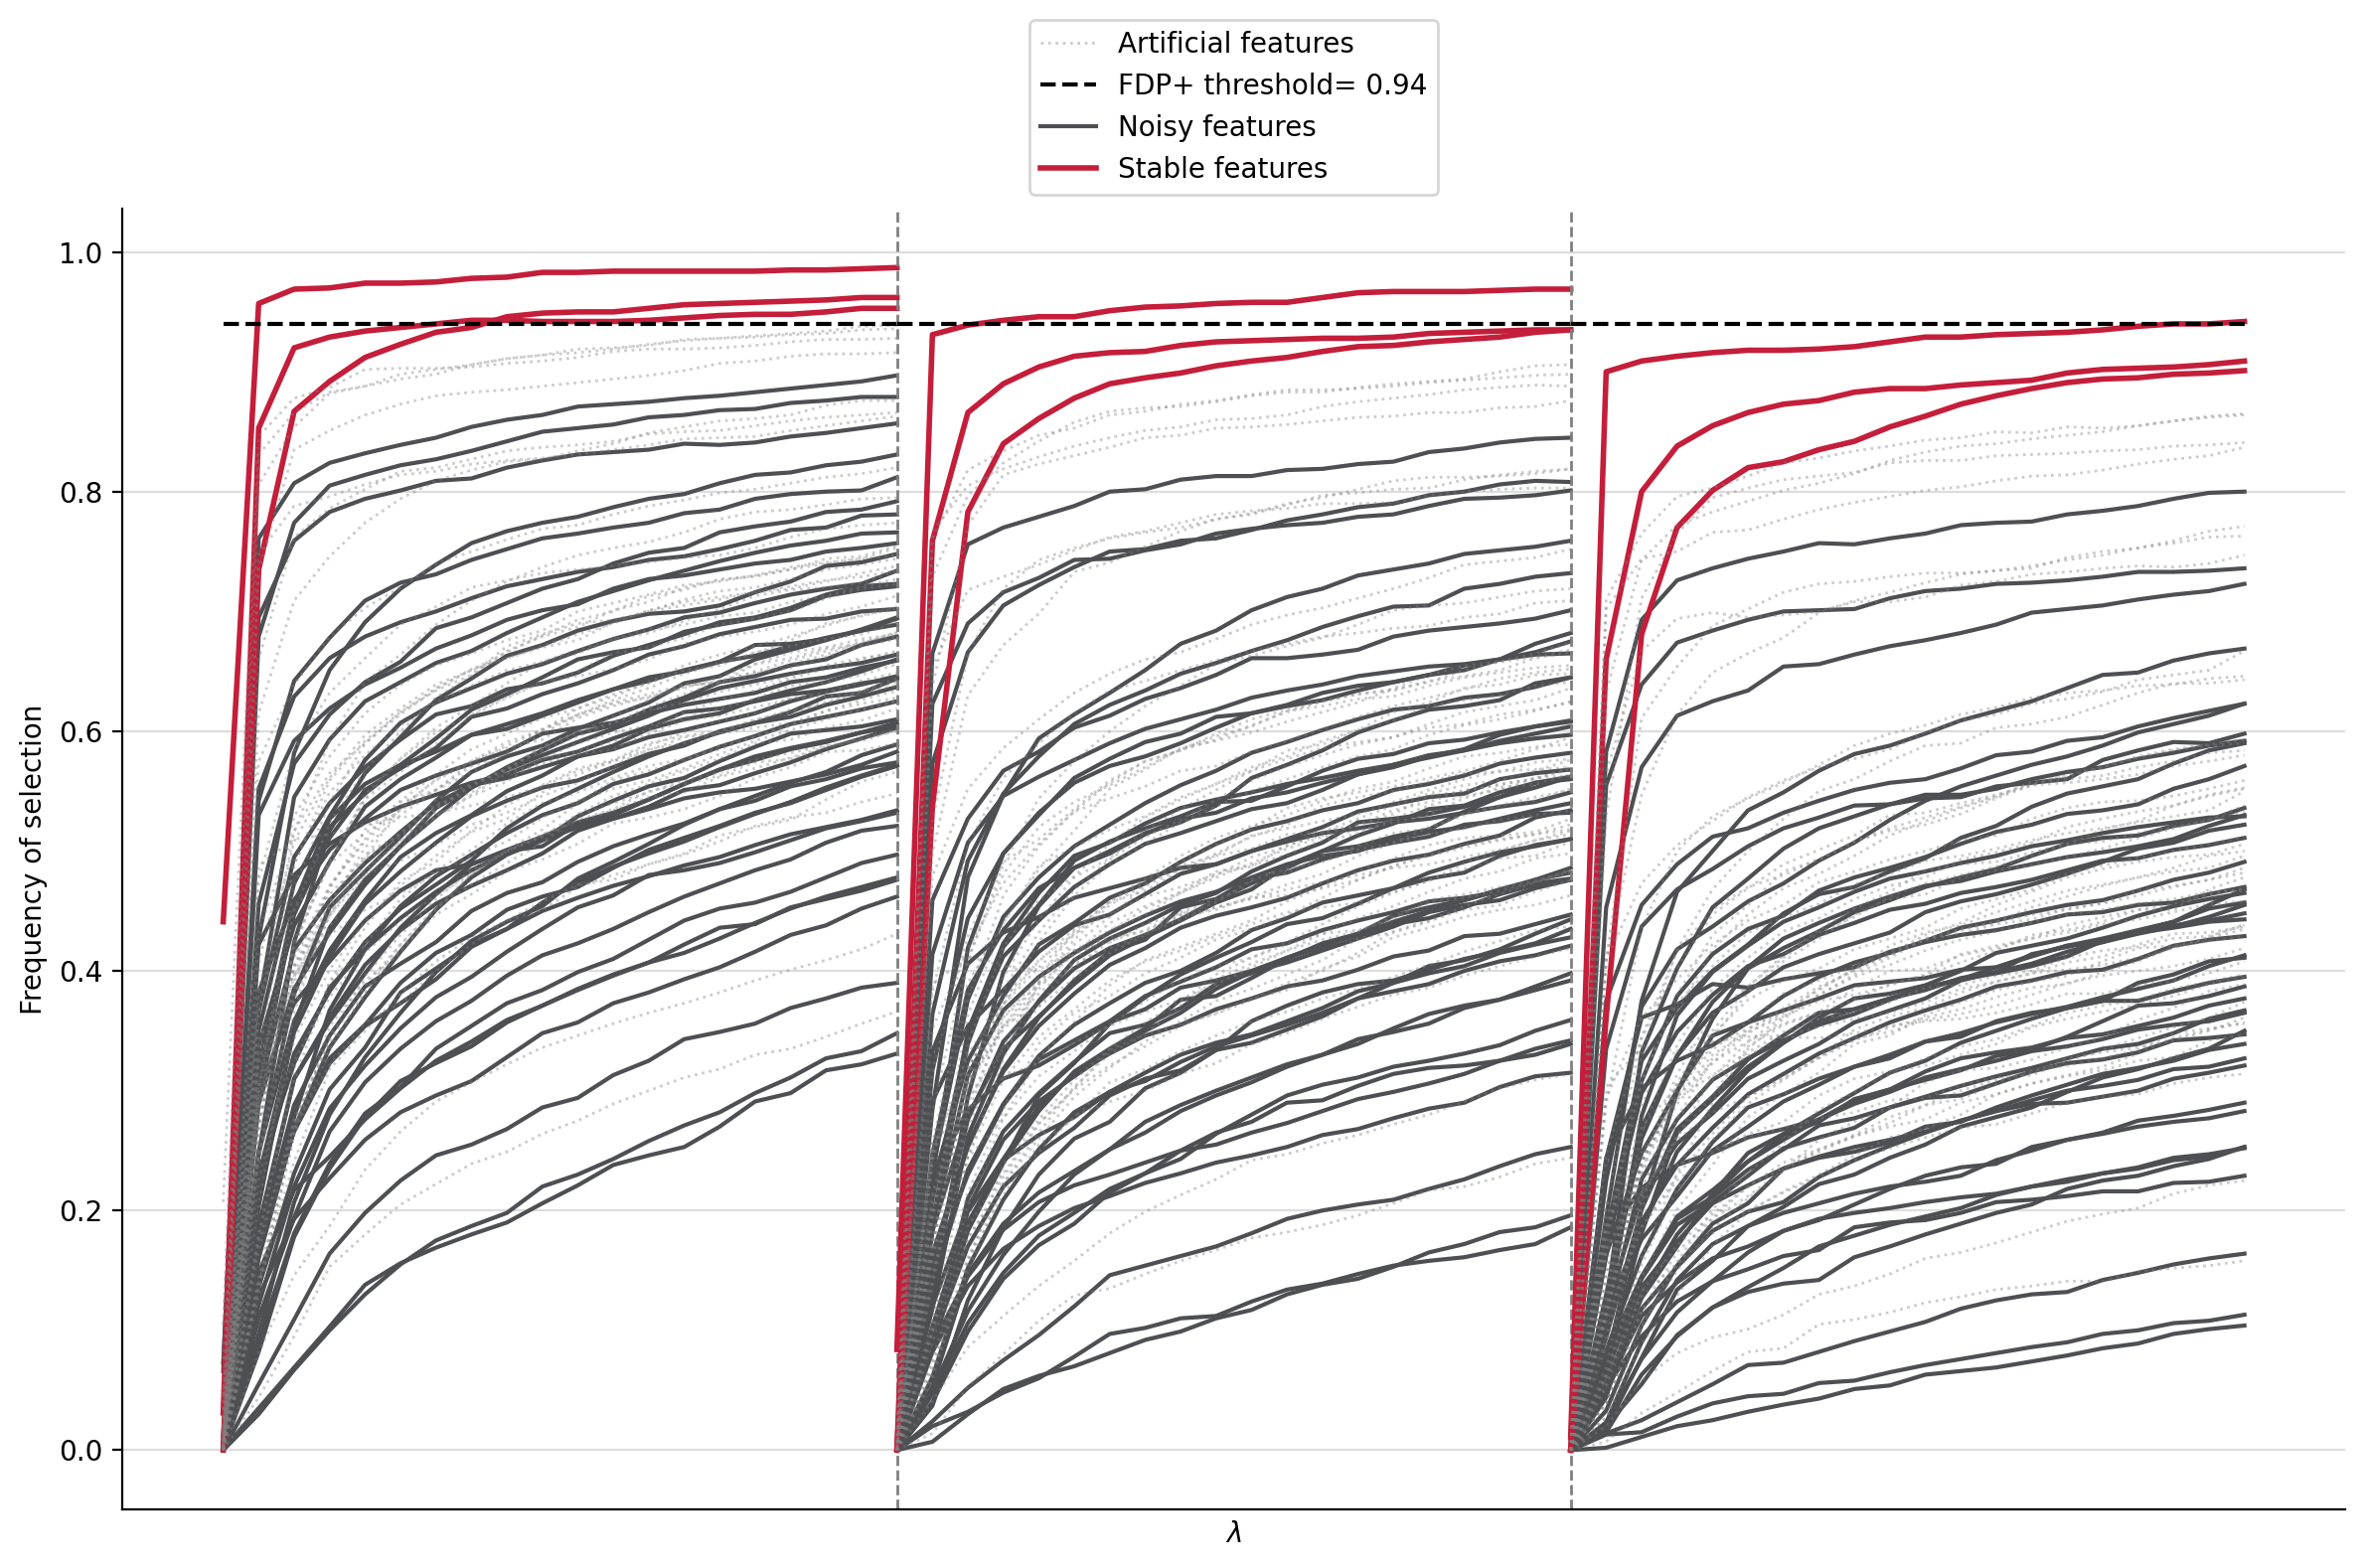

In [54]:
stabl_class = Stabl(
    base_estimator=clone(logit_en),
    lambda_grid="auto",
    n_lambda=20,
    artificial_type = 'knockoff',
    n_bootstraps=1000,
    random_state=4998, # Changed random state
    verbose=1
)
            
stabl_class.fit(x_train_final, train_y)
plot_stabl_path(stabl_class)
stable_features = stabl_class.get_feature_names_out()
for feature in stable_features:
    print("Assay of " + feature + " is: " + filtered_data_stabl[filtered_data_stabl['feature'] == feature]['assay'].unique())

## Obtain assays and p-value graphs for the top features

In [23]:
top_feature_names = ['CD161_pos_CD45RA_pos_Tregs, subset: CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161+CD45RA+', 'NKT_cells, subset: CD14-CD33-/CD3+/CD56+', 'monocytes, subset: CD14+CD33+', '']
top_feature_assays = ['CyTOF_phenotyping', 'CyTOF_phenotyping', 'CyTOF_phenotyping']

# Initialize lists to store the extracted search strings, subset values, and assays
search_strings = []
subset_values = []
assay = []

# Extract search_string, subset_value, and weight for each feature name
for i in range(len(top_feature_names)):
    feature = top_feature_names[i]
    if "subset: " in feature:
        # Split the string at "subset: " to separate the parts
        parts = feature.split(", subset: ")
        search_strings.append(parts[0])
        subset_values.append(parts[1])
    

    assay_feature = top_feature_assays[i]
    assay.append(assay_feature)

# Combine the extracted information into a DataFrame for better presentation
result_df = pd.DataFrame({
    "feature": search_strings,
    "subset": subset_values,
    "assay": assay
})

# Print the resulting DataFrame
result_df

,feature,subset,assay
0,CD161_pos_CD45RA_pos_Tregs,CD14-CD33-/CD3+/CD4+/CD25hiCD127low/CD161+CD45RA+,CyTOF_phenotyping
1,NKT_cells,CD14-CD33-/CD3+/CD56+,CyTOF_phenotyping
2,monocytes,CD14+CD33+,CyTOF_phenotyping


In [24]:
p_value_data_stabl = filtered_data_stabl
p_value_data_stabl['outcome'] = p_value_data_stabl['outcome'].astype('str')

In [25]:
from scipy.stats import ttest_ind
import os

# Define the function to perform and plot the analysis
def plot_feature_data(data, search_string, subset_value, assay_name, save_folder):
    # Filter the data for the specific feature
    top_feature_stabl = data[
        data['feature'].str.contains(search_string, na=False) & 
        (data['subset'] == subset_value)
    ]
    
    # Get min and max values for setting y-limits
    min_value = top_feature_stabl['value'].min()
    max_value = top_feature_stabl['value'].max()

    # Initialize the matplotlib figure
    plt.figure(figsize=(5, 5))

    # Define colors for each group
    colors = {'0': 'lightgray', '1': 'lightcoral'}
    errorbar_colors = {'0': 'black', '1': 'red'}
    
    # Perform the t-test
    group0_values = top_feature_stabl[top_feature_stabl['outcome'] == '0']['value']
    group1_values = top_feature_stabl[top_feature_stabl['outcome'] == '1']['value']
    # t_stat, p_value = ttest_ind(group0_values, group1_values)
    t_stat, p_value = ttest_ind(group0_values,
                                group1_values,
                                equal_var=False) # for unequal variances


    # Plot scatter plot with jitter for individual points for each group
    for group in top_feature_stabl['outcome'].unique():
        group_data = top_feature_stabl[top_feature_stabl['outcome'] == group]
        sns.violinplot(x='outcome', y='value', data=group_data, color=colors[group], alpha=0.7)

    # Calculate the mean and standard deviation for each group
    group_stats = top_feature_stabl.groupby('outcome')['value'].agg(['mean', 'std']).reset_index()

    # Add the error bars after the strip plots to ensure they are not covered
    for _, row in group_stats.iterrows():
        plt.errorbar(x=row['outcome'], y=row['mean'], yerr=row['std'], fmt='o', color=errorbar_colors[row['outcome']], capsize=5, capthick=2, elinewidth=2, zorder=3)

    # Add the significance line and asterisk if p-value <= 0.05
    if p_value < 0.05:
        significance_y = max_value + 0.1 * (max_value - min_value)
        plt.plot([0, 1], [significance_y, significance_y], color='black', zorder=2)
        plt.text(0.5, significance_y + 0.05 * (max_value - min_value), '*', ha='center', va='bottom', fontsize=20, color='black', zorder=3)

    # Set the y-axis limits
    plt.ylim(min_value - 0.35 * (max_value - min_value), max_value + 0.35 * (max_value - min_value))  # Adjust limits based on feature values

    # Improve visualization
    title_str = f"Assay: {assay_name}\nFeature: {search_string}"
    if p_value < 0.05:
        title_str += f"\n*p-value = {p_value} < 0.05"
    else:
        title_str += f"\np-value {p_value} > 0.05"

    plt.title(title_str, fontsize=12)
    plt.xlabel('Outcome')
    plt.ylabel('Value')

    # Save the plot as a PNG file        
    filename = f"{assay_name}_{search_string}.png"
    filepath = os.path.join(save_folder, filename)
    plt.savefig(filepath, format='png', dpi=300, bbox_inches='tight')

    # Close the plot to free up memory
    plt.close()

# Directory to save plots
save_folder = 'top features for stabl'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Plot each feature from result_df with proper dimensions and adjusted y-limits
for _, row in result_df.iterrows():
    plot_feature_data(
        data=p_value_data_stabl,
        search_string=row['feature'],
        subset_value=row['subset'],
        assay_name=row['assay'],
        save_folder=save_folder
    )


## Prediction Using Stabl's Features

In [28]:
# Overall pipeline
overall_pipe = Pipeline(
    steps=[
        ("preprocessing", preprocessing),  # We use the preprocessing pipeline previously defined
        ("feature_selection", stabl_class),  # We use Stabl for feature selection
        ("final_model", LogisticRegression(penalty="elasticnet", max_iter=int(1e6), solver="saga", class_weight="balanced", random_state=random_state, l1_ratio = 0.5))  # We use Logistic Regression as final model
    ]
)

In [29]:
# Fit pipeline to training data
overall_pipe.fit(train_x, train_y)

Stabl progress: 100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('variance_threshold',
                                  VarianceThreshold(threshold=0)),
                                 ('low_info_filter',
                                  LowInfoFilter(max_nan_fraction=0.4)),
                                 ('imputer', KNNImputer(n_neighbors=3)),
                                 ('std', StandardScaler())])),
                ('feature_selection',
                 Stabl(artificial_type='knockoff',
                       base_estimator=LogisticRegression(class_weight='balanced',
                                                         max_iter=1000...
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
                       lambda_grid='auto', n_lambda=20, random_state=4998,
                       verbose=1)),
                ('final_model',
                 LogisticRegression(class_weight='balanced', l1_ratio=0.5,
                                    max_iter=1000000, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

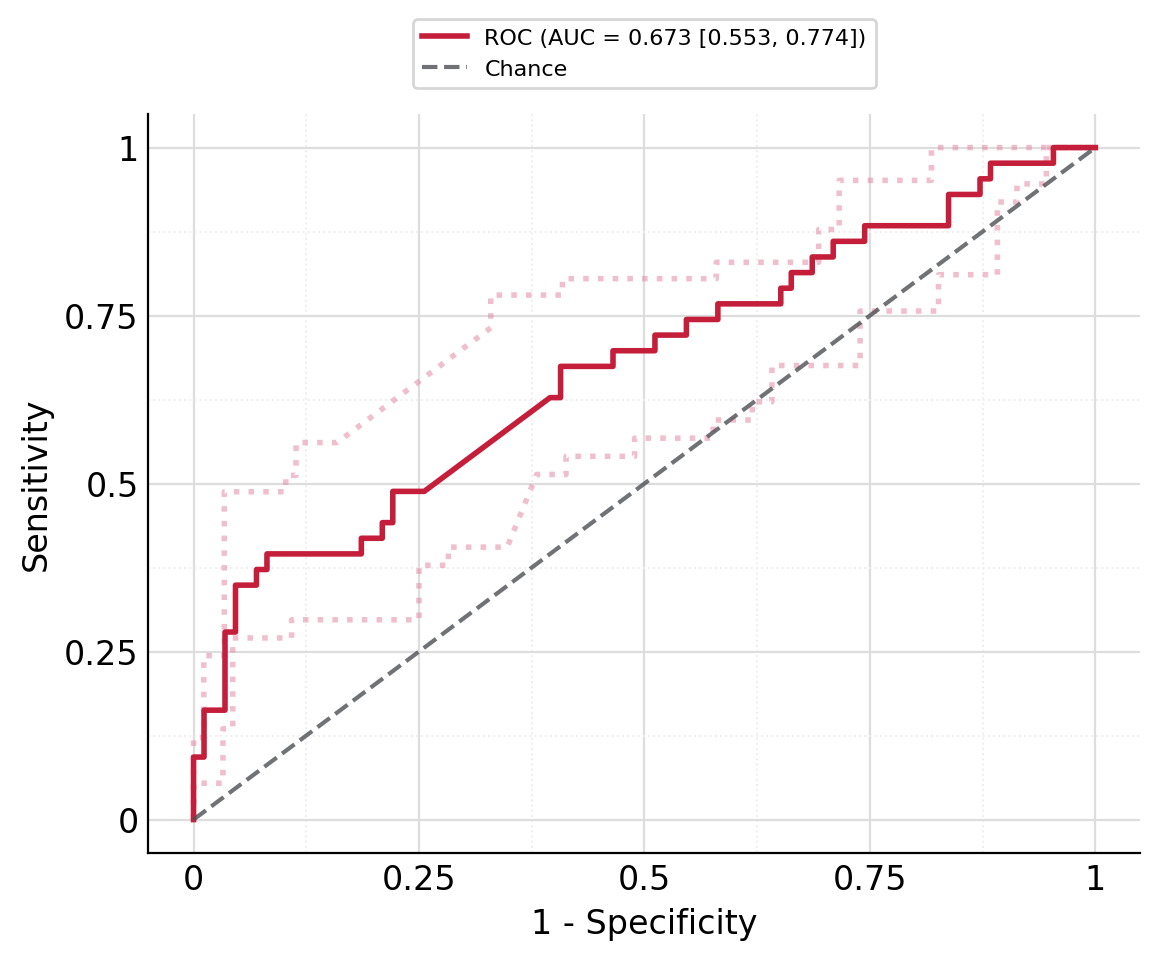

In [ ]:
# Predictions on Training Data
train_y_preds = overall_pipe.predict_proba(train_x)[:,1]
plot_roc(train_y, train_y_preds)
plt.show()

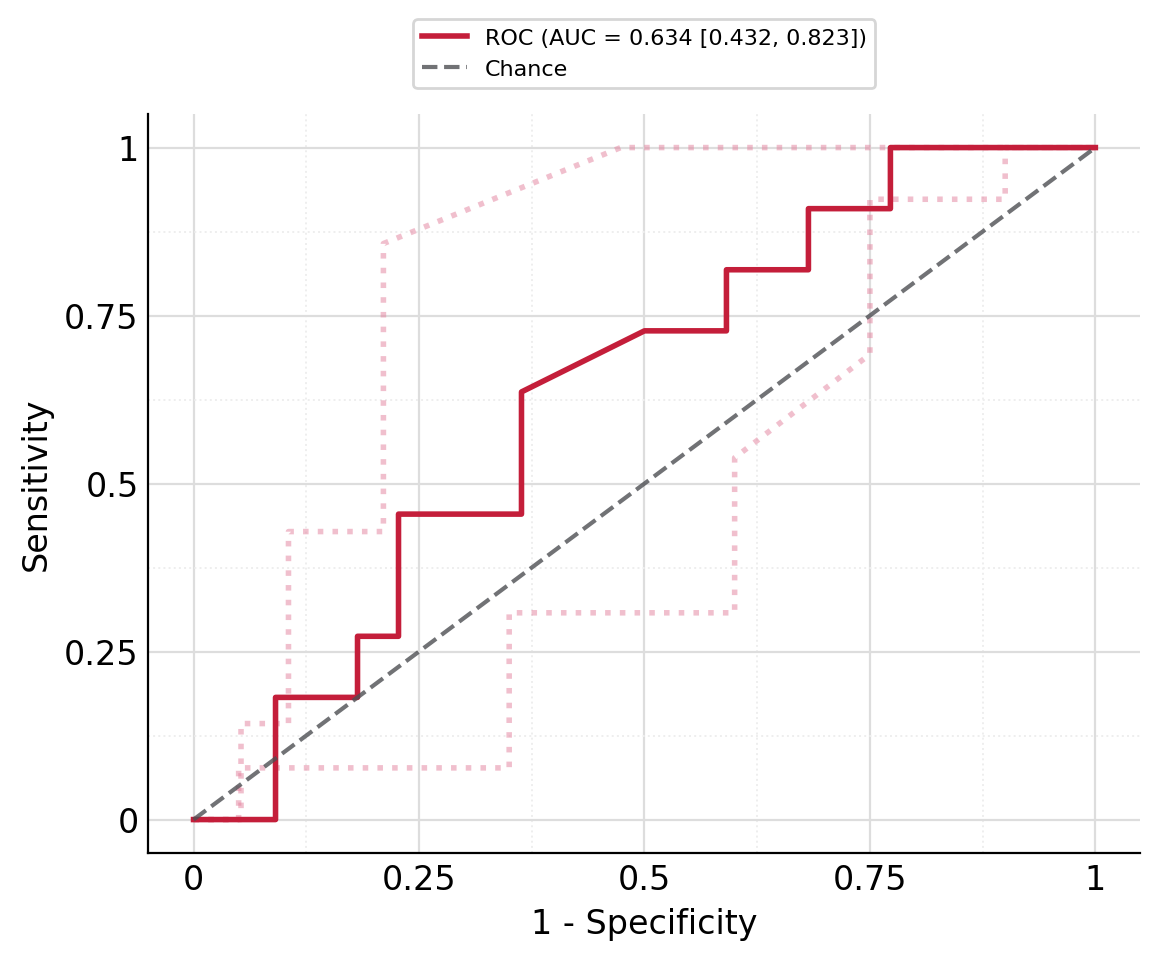

In [33]:
# Predictions on Test Data
test_y_preds = overall_pipe.predict_proba(test_x)[:,1]
plot_roc(test_y, test_y_preds)
plt.show()